<a href="https://colab.research.google.com/github/rim-yu/SGU_ANT6320_Assignment/blob/master/Exercise09_resnet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST CNN

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

### Data

In [0]:
path = untar_data(URLs.MNIST)

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [0]:
il = ImageList.from_folder(path, convert_mode='L')
# convert_mode = 'L' : gray scale로 이미지를 로드함. 
# testing, traing 모두 가져옴. 

In [0]:
il.items[9999]
# testing : 0 ~ 9,999

PosixPath('/root/.fastai/data/mnist_png/testing/6/4243.png')

In [0]:
il.items[69999]
# training : 10,000 ~ 69,999

PosixPath('/root/.fastai/data/mnist_png/training/6/31646.png')

In [0]:
defaults.cmap='binary'
# binary color map을 사용. 

In [0]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

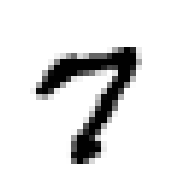

In [0]:
il[0].show()

In [0]:
sd = il.split_by_folder(train='training', valid='testing')
# 'traing' 폴더는 train dataset, 'testing' 폴더는 valid dataset. 

In [0]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/6')]

In [0]:
ll = sd.label_from_folder()
# 폴더명에서 레이블을 얻음.  
# ex) ./traning/7

In [0]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x, y = ll.train[0]

7 torch.Size([1, 28, 28])


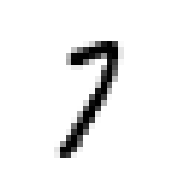

In [0]:
x.show()
print(y, x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])
# mnist dataset은 숫자 이미지이기에 회전 등 일반적인 transform을 할 경우 그 의미가 바뀌어버림. 
# [] : valid dataset에 대해 transform을 하지 않음. 

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [0]:
x, y = data.train_ds[0]

7


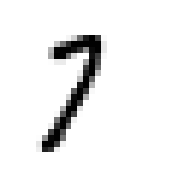

In [0]:
x.show()
print(y)
# transforms을 한 train dataset을 보여줌. 

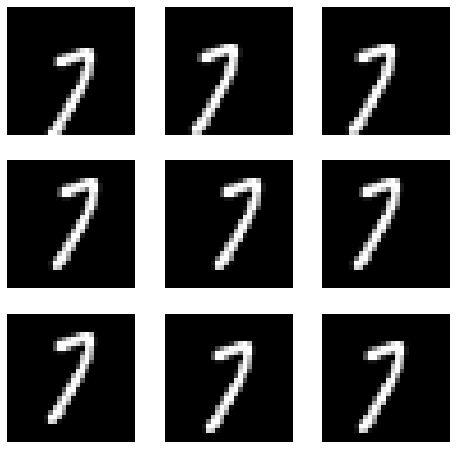

In [0]:
def _plot(i, j, ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))
# padding을 해서 약간씩 다른 위치에 있는 숫자를 가져올 수 있음. 

In [0]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

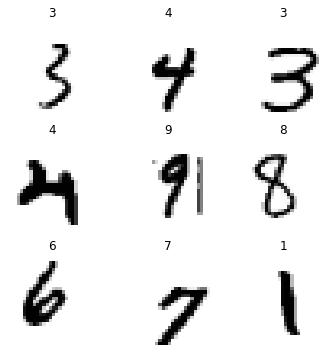

In [0]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [0]:
# 간단한 CNN 만들기. 
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [0]:
model = nn.Sequential(
    # gray scale이라 채널 하나. 
    # (1, 28, 28) -> (8, 14, 14)
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    # (8, 14, 14) -> (16, 7, 7)
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    # (16, 7, 7) -> (32, 4, 4)
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    # (32, 4, 4) -> (16, 2, 2)
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    # (16, 2, 2) -> (10, 1, 1)
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [0]:
xb = xb.cuda()

In [0]:
model(xb).shape

torch.Size([128, 10])

In [0]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


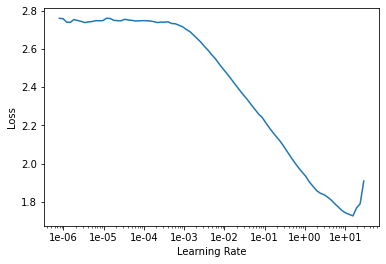

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.228296,0.186437,0.938900,00:36
1,0.124631,0.092580,0.970800,00:36
2,0.067851,0.035703,0.989300,00:36


### Refactor

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.224636,0.206630,0.937400,00:35
1,0.191339,0.292437,0.911600,00:35
2,0.152519,0.176042,0.941100,00:35
3,0.135634,0.199238,0.944500,00:35
4,0.109873,0.105914,0.968100,00:35
5,0.095548,0.082010,0.975300,00:35
6,0.083854,0.056416,0.982600,00:35
7,0.065886,0.038014,0.988200,00:35
8,0.047846,0.029945,0.990300,00:35
9,0.041303,0.028234,0.990100,00:35


### Resnet-ish

https://blog.naver.com/arar2017/221800049197

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


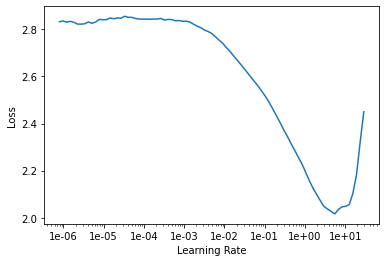

In [0]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.202007,0.261741,0.927700,00:40
1,0.137552,0.179036,0.944400,00:40
2,0.104725,0.113359,0.963100,00:40
3,0.092385,0.057539,0.980700,00:40
4,0.081682,0.057715,0.981800,00:40
5,0.063187,0.067085,0.977300,00:41
6,0.055458,0.078210,0.974700,00:41
7,0.047234,0.033524,0.989600,00:40
8,0.037373,0.027661,0.991000,00:40
9,0.026813,0.015807,0.995000,00:41


In [0]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________

## fin